In [449]:
from xai.policy import *
from xai.buffer import Buffer
from xai.bytes import GigaBytes
from numpy import uint8
from numpy.typing import NDArray
import matplotlib.pyplot as plt

import mnist
import torch
import random
import shap
import numpy as np

In [489]:
latent_dim = 5

In [490]:
images = torch.from_numpy(mnist.train_images())
images = images.float()/255.0

labels = torch.from_numpy(mnist.train_labels())
labels_one_hot = torch.zeros((labels.shape[0],10)).float()
labels_one_hot[torch.arange(0,labels.shape[0]),labels.int()] = 1.0

images.shape, labels_one_hot.shape

(torch.Size([60000, 28, 28]), torch.Size([60000, 10]))

In [491]:
encoder = Policy.new((28,28),latent_dim, hidden_activation="ReLU")
decoder = Policy.new(encoder.output_dim,encoder.input_dim, hidden_activation="ReLU")
autoencoder = encoder + decoder
autoencoder

Sequential(
  (0): Linear(in_features=784, out_features=524, bias=True)
  (1): ReLU()
  (2): Linear(in_features=524, out_features=264, bias=True)
  (3): ReLU()
  (4): Linear(in_features=264, out_features=5, bias=True)
  (5): Linear(in_features=5, out_features=264, bias=True)
  (6): ReLU()
  (7): Linear(in_features=264, out_features=524, bias=True)
  (8): ReLU()
  (9): Linear(in_features=524, out_features=784, bias=True)
)

In [505]:
stats = autoencoder.adam().fit(
    X=images,
    Y=images,
    epochs=1500,
    batch_size=128,
    loss_criterion="MSELoss",
    verbose=True,
    info="Autoencoder test"
)
stats[5:].plot_loss()

Loss: 0.024176: 100%|██████████| 1500/1500 [00:24<00:00, 61.75it/s]


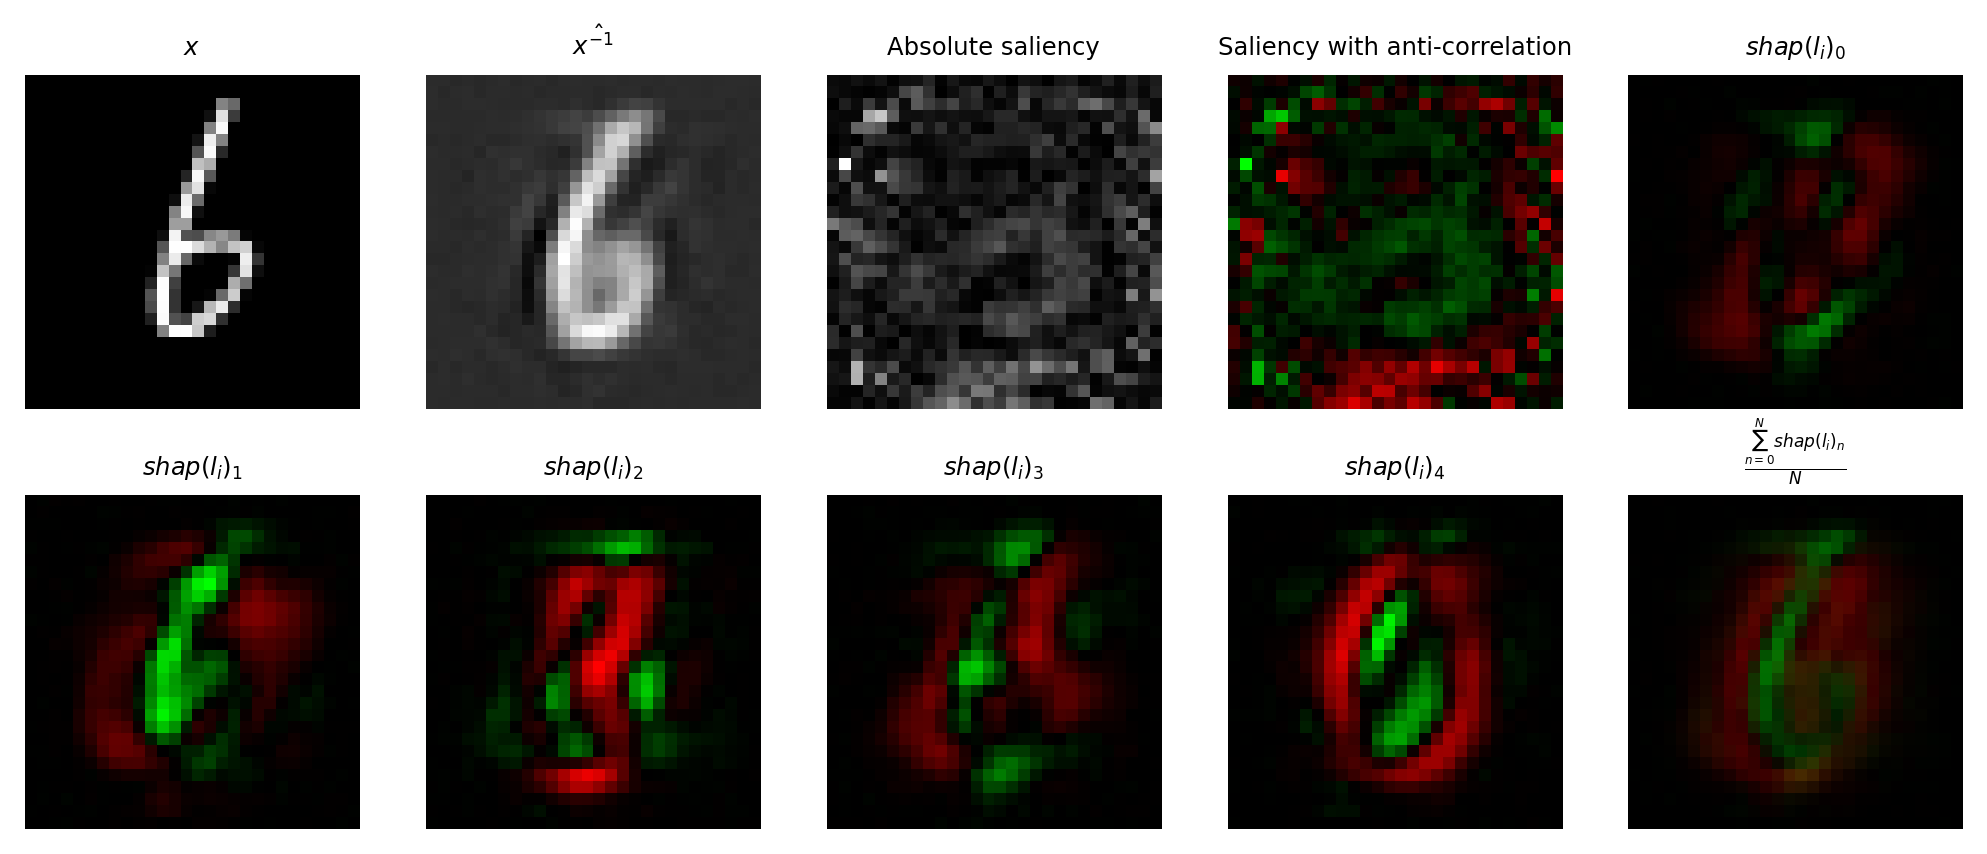

In [545]:
idx = random.randint(0,len(images))
X = images[idx]
X_inv = autoencoder(X)
digit = X_inv.tensor().argmax().item()

fig = plt.figure(dpi=250, figsize=(10,4)) 
fig.add_subplot(2,5,1)
plt.imshow(X, cmap="gray") 
plt.axis('off')
plt.title(f'$x$', size=7)

fig.add_subplot(2,5, 2)
plt.imshow(X_inv.numpy(), cmap="gray") 
plt.axis('off')
plt.title(f'$\\hat{{x^{{-1}}}}$', size=7)

abs_saliency = X_inv.saliency(lambda t: t.sum())

fig.add_subplot(2,5,3)
plt.imshow(abs_saliency, cmap="gray") 
plt.axis('off')
plt.title(f"Absolute saliency", size=7)

gradients = X_inv.gradients(lambda t: t.sum())
min,max = gradients.min(), gradients.max()
red = torch.where(gradients < 0, gradients/min, torch.zeros_like(gradients))
green = torch.where(gradients > 0, gradients/max, torch.zeros_like(gradients))
saliency_with_corr = torch.zeros((28,28,3), dtype=torch.float32, device="cpu")
saliency_with_corr[:,:,0] = red
saliency_with_corr[:,:,1] = green

fig.add_subplot(2,5,4)
plt.imshow(saliency_with_corr, cmap="gray") 
plt.axis('off')
plt.title(f"Saliency with anti-correlation", size=7)

data = encoder(images).numpy()
explainer = shap.PermutationExplainer(lambda t: decoder(torch.from_numpy(t)).numpy().reshape((-1,784)), masker=data)
shap_values: shap.Explanation = explainer(data[idx:idx+1], max_evals=1001)[0]
shap_values = np.array(shap_values.values).reshape((latent_dim,28,28))

min,max = shap_values.min(), shap_values.max()
red = np.where(shap_values < 0, shap_values/min, np.zeros_like(shap_values))
green = np.where(shap_values > 0, shap_values/max, np.zeros_like(shap_values))

shap_images = []
for i in range(5):
    image = np.zeros((28,28,3), dtype=np.float32)
    image[:,:,0] = red[i]
    image[:,:,1] = green[i]
    shap_images.append(image)
    fig.add_subplot(2,5,i+5)
    plt.imshow(shap_images[-1], cmap="gray")
    plt.axis('off')
    plt.title(f'$shap(l_{{i}})_{i}$', size=7)

fig.add_subplot(2,5,10)
plt.imshow(np.stack(shap_images).mean(axis=0))
plt.axis('off')
plt.title(f'$\\frac{{\sum_{{n=0}}^{{N}}{{shap(l_{{i}})_{{n}}}}}}{{N}}$', size=7)
plt.show()

In [486]:
classifier_head = Policy.new(encoder.output_dim,10, hidden_activation="ReLU")
classifier = encoder + classifier_head
classifier

Sequential(
  (0): Linear(in_features=784, out_features=524, bias=True)
  (1): ReLU()
  (2): Linear(in_features=524, out_features=264, bias=True)
  (3): ReLU()
  (4): Linear(in_features=264, out_features=5, bias=True)
  (5): Linear(in_features=5, out_features=6, bias=True)
  (6): ReLU()
  (7): Linear(in_features=6, out_features=8, bias=True)
  (8): ReLU()
  (9): Linear(in_features=8, out_features=10, bias=True)
)

In [323]:
stats = classifier_head.adam().fit(
    X=encoder(images),
    Y=torch.concat([labels_one_hot, labels_one_hot]),
    epochs=5000,
    batch_size=64,
    loss_criterion="CrossEntropyLoss",
    verbose=True,
    info="Classifier test"
)
stats.plot_loss()

Loss: 1.076507: 100%|██████████| 5000/5000 [00:23<00:00, 211.92it/s]


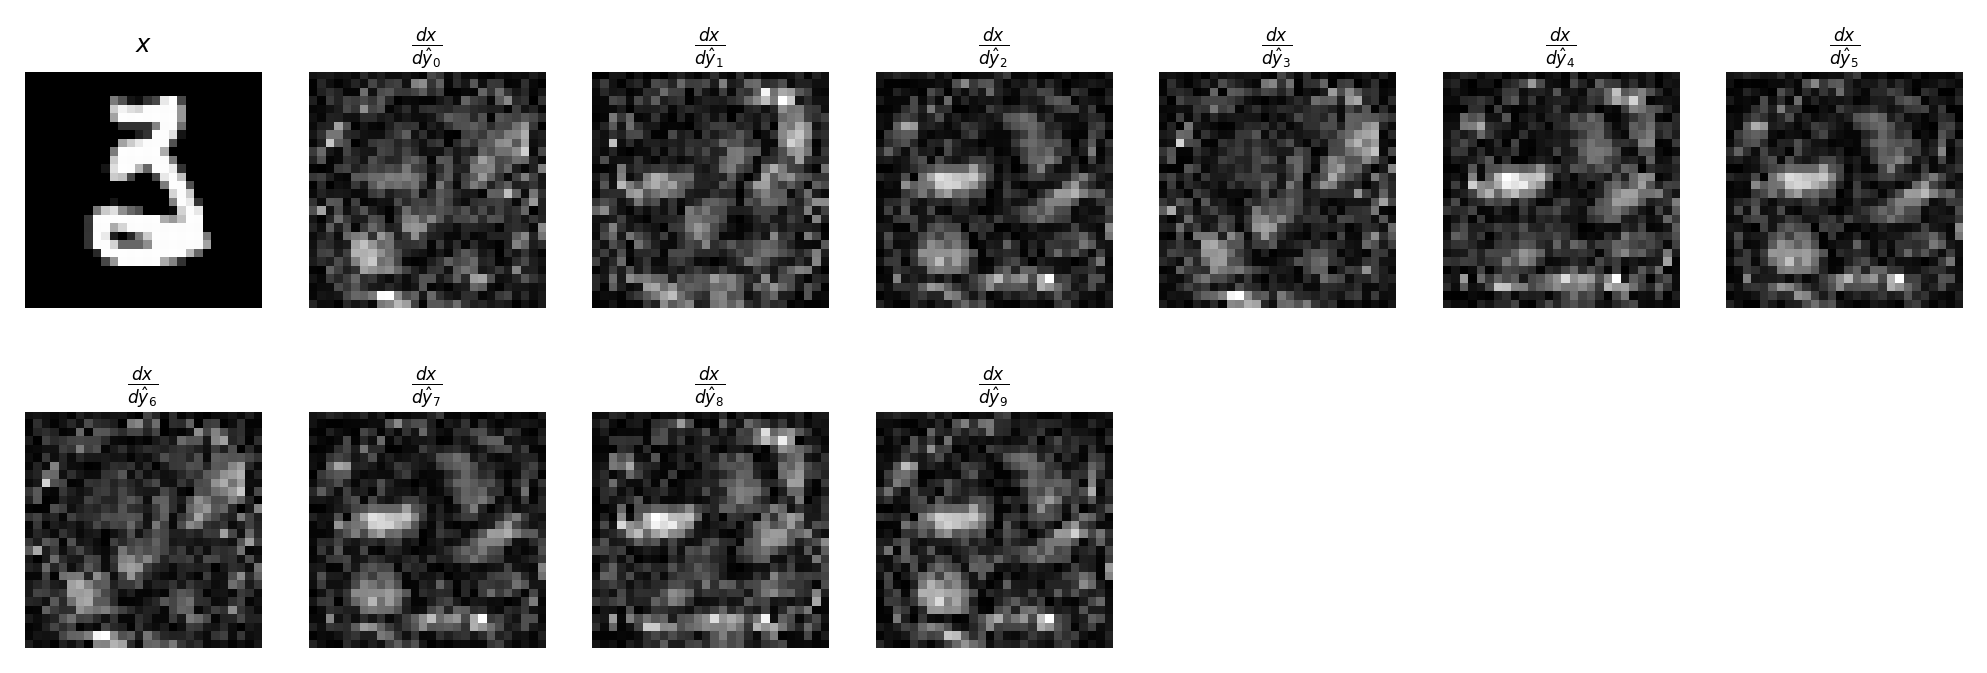

In [487]:
idx = random.randint(0,len(images))
X = images[idx]
feedforward = classifier(X)

Y = feedforward.numpy()
digit = feedforward.tensor().argmax().item()

fig = plt.figure(dpi=250, figsize=(10,5)) 
fig.add_subplot(3,7, 1)
plt.imshow(X, cmap="gray") 
plt.axis('off')
plt.title(f'$x$', size=7)

saliencies = []
for i in range(10):
    fig.add_subplot(3,7,i+2)
    saliencies.append(feedforward.saliency(lambda t: t[i]))
    plt.imshow(saliencies[-1], cmap="gray")
    plt.axis('off')
    plt.title(f'$\\frac{{dx}}{{d\hat y_{i}}}$', size=7)

Disk used: 0.50/0.50GB: : 1592it [00:02, 574.61it/s]


(Buffer(use_ram=False, entries=1592, size=499.90MB, capacity=99.98%),
 torch.Size([280, 280]))

Sequential(
  (0): Linear(in_features=78400, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=32, bias=True)
  (5): ReLU()
  (6): Linear(in_features=32, out_features=5, bias=True)
  (7): Linear(in_features=5, out_features=32, bias=True)
  (8): ReLU()
  (9): Linear(in_features=32, out_features=64, bias=True)
  (10): ReLU()
  (11): Linear(in_features=64, out_features=256, bias=True)
  (12): ReLU()
  (13): Linear(in_features=256, out_features=78400, bias=True)
)

Loss: 0.053960:   6%|▌         | 59/1000 [00:20<05:30,  2.85it/s]


KeyboardInterrupt: 

In [ ]:
X = big_images[random.randint(0,len(big_images))]
feedforward = big_autoencoder.predict(X)

Y = feedforward.numpy()

dY = feedforward.derivative(lambda t: t.sum(), order=1).cpu().numpy()

fig = plt.figure(figsize=(10,7)) 
fig.add_subplot(1,3,1)
plt.imshow(X, cmap="gray") 
fig.add_subplot(1,3,2)
plt.imshow(Y, cmap="gray") 
fig.add_subplot(1,3,3)
plt.imshow(dY, cmap="gray")